## <span style=color:blue>In this notebook, we illustrate how to get the NDVI value for a single cell of size roughly 100m x 100m.  This will give you the basic machinery needed to gather sequences of NDVI values that can be incorporated into your ML pipelines   </span>

### <span style=color:blue>First, we create function that retrieves the NVDI for a given year, week, and 100m x 100m cell centered at some lon-lat   </span>

<span style=color:blue>To get started with accessing SentinelHub using Python, I found the site https://sentinelhub-py.readthedocs.io/en/latest/index.html to be helpful.  In particular, you can find and download the SentinelHub-py github repository at https://github.com/sentinel-hub/sentinelhub-py, and then work through some of the Examples.</span>

<span style=color:blue>First, we set up access to SentinelHub</span>

In [68]:
import os

# To access SentinelHub you need a client_id and client_secret.
# To get your own access to SentinelHub, go
#    to https://docs.sentinel-hub.com/api/latest/api/overview/authentication/.
#    From there you can get a user name and password for a free 30-day trial.
#    Once you sign in, find you way to
#    https://apps.sentinel-hub.com/dashboard/, and from the 
#    "User Settings" area you can create an OAuth client -- this will give you 
#    a Client_ID and a Client_Secret.  (I had to create a couple of these in order
#    to get one that worked.  Also, they do expire after a while...)
# I put my client_ID and client_secret into some environment variables

#SENTINEL_CLIENT_ID = os.getenv('SENTINEL_CLIENT_ID')
#SENTINEL_CLIENT_SECRET = os.environ.get('SENTINEL_CLIENT_SECRET')

SENTINEL_CLIENT_ID = "d1d29118-6bef-4c91-9be6-8688201955c9"
SENTINEL_CLIENT_SECRET = ";dnZx}*X,.NvH#.36PlB6H:{x;.p9.m{n)phZE-Y"

<span style=color:blue>Now create a client for accessing SentinelHub     </span>

In [69]:
from sentinelhub import SHConfig

config = SHConfig()

# using third client id and secret, from 2023-05-26
config.sh_client_id = SENTINEL_CLIENT_ID
config.sh_client_secret = SENTINEL_CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")
else:
    print("Successfully set up SentinelHub client")

Successfully set up SentinelHub client


<span style=color:blue> Not sure why sentinelhub examples include this next cell, but I will blindly imitate them   </span>

In [70]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

<span style=color:blue>Importing useful things from SentinelHub  </span>

In [71]:
import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same 
#     folder as this notebook.
# As a slight variation, I have cloned the sentinelhub-py repo into my local github, 
#     and grab utils.py from there
sys.path.append('/Users/jinholee/Desktop_local/2023_Spring_FoodSecurity/HW3/sentinelhub-py/examples/')
from utils import plot_image

### <span style=color:blue>As a small warm-up exercise, to help you get familiar with accessing data from SentinalHub, here is an example of pulling some RGB data and viewing it     </span>

<span style=color:blue> First, identifying a couple of bounding boxes to work with. Note that the second example is focusing on a single cell with size about 100m x 100m. </span>

<span style=color:blue>Once you have the bounds for a box, then you can initialize a "BBox" object and specify both its bounds and also the desired resolution.    </span>

<span style=color:blue>Note: by experimenting I found that you cannot request an image where the box has > 2500 pixels along either direction.  Also, each pixel can be at most 200 m x 200 m.  This puts an effective limit on the size of box you can retrieve with one call to SentinelHub -- about 500km x 500km at the equator.   </span>

<span style=color:blue>Getting RGB for corner_iowa_bbox     </span>

<span style=color:blue>Here is some helpful text from the example notebook "process_request.ipynb" that I have been following for this part of my notebook </span>

We build the request according to the API Reference, using the SentinelHubRequest class. Each Process API request also needs an evalscript.

The information that we specify in the SentinelHubRequest object is:

    an evalscript,
    a list of input data collections with time interval,
    a format of the response,
    a bounding box and it's size (size or resolution).

The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L1C bands.

With request_true_color_1_day, the image from Jun 12th 2020 is downloaded. Without any additional parameters in the evalscript, the downloaded data will correspond to reflectance values in UINT8 format (values in 0-255 range).

<span style=color:blue>I am also experimenting with request_true_color_7_day, to see what happens if my interval is multiple days. </span>

In [132]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color_1_day = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2018-05-08", "2018-05-09"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_kansas_bbox,
    size=corner_kansas_size,
    config=config,
)

request_true_color_7_day = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2018-10-15", "2018-10-19"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_kansas_bbox,
    size=corner_kansas_size,
    config=config,
)

<span style=color:blue>Invoking these two functions    </span>

In [133]:
corner_kansas_color_imgs_1_day = request_true_color_1_day.get_data()
corner_kansas_color_imgs_7_day = request_true_color_7_day.get_data()

<span style=color:blue>Exploring the outputs.  It appears that the multi-day gives back the sums of the values for the days that are contributing.    </span>

In [134]:
print(f"Returned data is of type = {type(corner_kansas_color_imgs_1_day)} and length {len(corner_kansas_color_imgs_1_day)}.")
print(f"Single element in the list is of type {type(corner_kansas_color_imgs_1_day[-1])} and has shape {corner_kansas_color_imgs_1_day[-1].shape}")
print()
print(corner_kansas_color_imgs_1_day)


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (580, 484, 3)

[array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)]


In [95]:
print(f"Returned data is of type = {type(corner_kansas_color_imgs_7_day)} and length {len(corner_kansas_color_imgs_7_day)}.")
print(f"Single element in the list is of type {type(corner_kansas_color_imgs_7_day[-1])} and has shape {corner_kansas_color_imgs_7_day[-1].shape}")
print()
print(corner_kansas_color_imgs_7_day)


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (725, 787, 3)

[array([[[38, 36, 35],
        [28, 31, 30],
        [24, 29, 28],
        ...,
        [43, 37, 35],
        [50, 40, 38],
        [53, 40, 38]],

       [[20, 27, 26],
        [27, 31, 30],
        [25, 30, 29],
        ...,
        [30, 31, 31],
        [28, 30, 30],
        [25, 29, 30]],

       [[24, 29, 28],
        [29, 32, 31],
        [26, 29, 29],
        ...,
        [28, 31, 31],
        [27, 30, 30],
        [22, 26, 27]],

       ...,

       [[35, 34, 34],
        [34, 33, 33],
        [44, 37, 36],
        ...,
        [42, 37, 36],
        [36, 33, 33],
        [32, 32, 32]],

       [[41, 37, 35],
        [33, 33, 33],
        [46, 36, 36],
        ...,
        [38, 34, 34],
        [37, 33, 33],
        [41, 36, 35]],

       [[46, 35, 34],
        [44, 34, 33],
        [36, 34, 36],
        ...,
        [31, 32, 31],
   

<span style=color:blue>To plot first single-day image, we have to  get the values to be between 0 and 1.  In fact, we first scale to (0,1) but then multiply by 3.5 to brighten the picture    </span>

Type of each value in ci_image_1_day: uint8


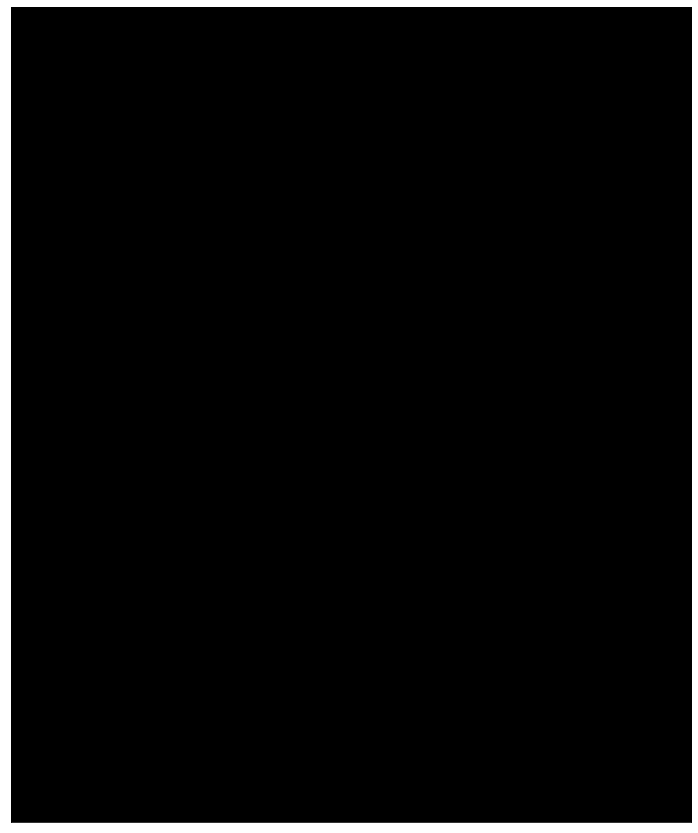

In [135]:
ci_image_1_day = corner_kansas_color_imgs_1_day[0]
print(f"Type of each value in ci_image_1_day: {ci_image_1_day.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(ci_image_1_day, factor=3.5 / 255, clip_range=(0, 1))

<span style=color:blue>Let's look at how the 7-day interval turns out...   </span>

Type of each value in ci_image_7_day: uint8


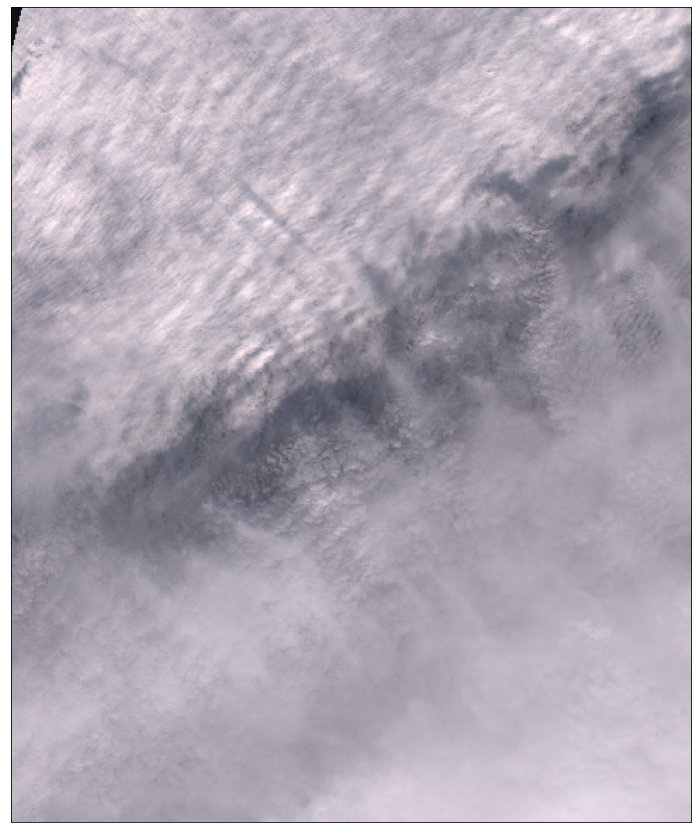

In [136]:
ci_image_7_day = corner_kansas_color_imgs_7_day[0]
print(f"Type of each value in ci_image_7_day: {ci_image_7_day.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(ci_image_7_day, factor=1 / 255, clip_range=(0, 1))

### <span style=color:blue>Oh my - the clouds are dominating the top part of image!! Please see the example of building cloud masks in the file process_request.ipynb in the Examples area of the sentinelhub-py github repo.    </span>

<span style=color:blue>Building a sentinel request to pull NDVI values for a single 100m x 100m cell.  Recall the formula for NDVI is (B08 - B04) / (B08 + B04).</span>

In [159]:
# Recall that we built point_iowa_bbox (along with point_iowa_size) 
# to be a single pixel of size 100m x 100m, that was in a soybean field in 2022

# Mid KANSAS / Latitude: 38.27312, Longitude: -98.5821872

def get_NDVI_target_region(lon, lat, year):

    ## State-County lon, lat data setting
    rounded_lon = round(lon, 3)
    rounded_lat = round(lat, 3)
    rounded_lon_end = round(rounded_lon + 0.001, 3)
    rounded_lat_end = round(rounded_lat + 0.001, 3)

    print(rounded_lon, rounded_lat)
    print(rounded_lon_end, ',', rounded_lat_end)

    point_kansas_wgs84 = (rounded_lon, rounded_lat, rounded_lon_end, rounded_lat_end)    
    corner_kansas_coords_wgs84 = (-95.317021-0.400, 37.888217-0.400, -95.317021+0.400, 37.888217+0.400)

    ## Sentinel Setting
    resolution1 = 150
    corner_kansas_bbox = BBox(bbox=corner_kansas_coords_wgs84, crs=CRS.WGS84)
    corner_kansas_size = bbox_to_dimensions(corner_kansas_bbox, resolution=resolution1)

    resolution2 = 100
    point_kansas_bbox = BBox(bbox=point_kansas_wgs84, crs=CRS.WGS84)
    point_kansas_size = bbox_to_dimensions(point_kansas_bbox, resolution=resolution2)

    print(f"For corner Kansas box, image shape at {resolution1} m resolution:{corner_kansas_size} pixels")
    print()

    print(f"For point Kansas box, image shape at {resolution2} m resolution: {point_kansas_size} pixels")
    print()
    
    ## Year format setting
    corner_start_date = str(year) + '-05-01'
    corner_end_date = str(year) + '-05-02'    
    
    poiont_start_date = str(year) + '-05-01'
    poiont_end_date = str(year) + '-05-06'
    
    evalscript_NVDI_bands = """
        //VERSION=3

        function setup() {
            return {
                input: [{
                    bands: ["B04", "B08"]
                }],
                output: {
                    bands: 2
                }
            };
        }

        function evaluatePixel(sample) {
            return [sample.B04, sample.B08];
        }
    """
    request_NVDI_corner = SentinelHubRequest(
        evalscript=evalscript_NVDI_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=(corner_start_date, corner_end_date),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=corner_kansas_bbox,
        size=corner_kansas_size,
        config=config,
    )

    request_NVDI_point = SentinelHubRequest(
        evalscript=evalscript_NVDI_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=(poiont_start_date, poiont_end_date),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=point_kansas_bbox,
        size=point_kansas_size,
        config=config,
    )

    print(request_NVDI_point)
    data = request_NVDI_point.get_data()
    print(data)
    print()
    B04 = data[0][0][0][0]
    B08 = data[0][0][0][1]
    print(B04, B08)
    NVDI = (B08-B04)/(B08+B04)
    print('\nNVDI is: ', NVDI)
    print()
    
    if np.isnan(NVDI):
        poiont_start_date = str(year) + '-04-25'
        poiont_end_date = str(year) + '-04-30'
        
        request_NVDI_point = SentinelHubRequest(
            evalscript=evalscript_NVDI_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=(poiont_start_date, poiont_end_date),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=point_kansas_bbox,
            size=point_kansas_size,
            config=config,
        )

        print(request_NVDI_point)
        data = request_NVDI_point.get_data()
        print(data)
        print()
        B04 = data[0][0][0][0]
        B08 = data[0][0][0][1]
        print(B04, B08)
        NVDI = (B08-B04)/(B08+B04)
        print('\nNVDI is: ', NVDI)
        print()

    if np.isnan(NVDI):
        poiont_start_date = str(year) + '-05-06'
        poiont_end_date = str(year) + '-05-11'
        
        request_NVDI_point = SentinelHubRequest(
            evalscript=evalscript_NVDI_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=(poiont_start_date, poiont_end_date),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=point_kansas_bbox,
            size=point_kansas_size,
            config=config,
        )

        print(request_NVDI_point)
        data = request_NVDI_point.get_data()
        print(data)
        print()
        B04 = data[0][0][0][0]
        B08 = data[0][0][0][1]
        print(B04, B08)
        NVDI = (B08-B04)/(B08+B04)
        print('\nNVDI is: ', NVDI)
        print()


    if np.isnan(NVDI):
        poiont_start_date = str(year) + '-05-11'
        poiont_end_date = str(year) + '-05-16'
        
        request_NVDI_point = SentinelHubRequest(
            evalscript=evalscript_NVDI_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=(poiont_start_date, poiont_end_date),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=point_kansas_bbox,
            size=point_kansas_size,
            config=config,
        )

        print(request_NVDI_point)
        data = request_NVDI_point.get_data()
        print(data)
        print()
        B04 = data[0][0][0][0]
        B08 = data[0][0][0][1]
        print(B04, B08)
        NVDI = (B08-B04)/(B08+B04)
        print('\nNVDI is: ', NVDI)
        print()

    if np.isnan(NVDI):
        poiont_start_date = str(year) + '-05-16'
        poiont_end_date = str(year) + '-05-21'
        
        request_NVDI_point = SentinelHubRequest(
            evalscript=evalscript_NVDI_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=(poiont_start_date, poiont_end_date),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=point_kansas_bbox,
            size=point_kansas_size,
            config=config,
        )

        print(request_NVDI_point)
        data = request_NVDI_point.get_data()
        print(data)
        print()
        B04 = data[0][0][0][0]
        B08 = data[0][0][0][1]
        print(B04, B08)
        NVDI = (B08-B04)/(B08+B04)
        print('\nNVDI is: ', NVDI)
        print()

    if np.isnan(NVDI):
        poiont_start_date = str(year) + '-05-21'
        poiont_end_date = str(year) + '-05-26'
        
        request_NVDI_point = SentinelHubRequest(
            evalscript=evalscript_NVDI_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=(poiont_start_date, poiont_end_date),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=point_kansas_bbox,
            size=point_kansas_size,
            config=config,
        )

        print(request_NVDI_point)
        data = request_NVDI_point.get_data()
        print(data)
        print()
        B04 = data[0][0][0][0]
        B08 = data[0][0][0][1]
        print(B04, B08)
        NVDI = (B08-B04)/(B08+B04)
        print('\nNVDI is: ', NVDI)
        print()
        

    if np.isnan(NVDI):
        poiont_start_date = str(year) + '-05-26'
        poiont_end_date = str(year) + '-05-31'
        
        request_NVDI_point = SentinelHubRequest(
            evalscript=evalscript_NVDI_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=(poiont_start_date, poiont_end_date),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=point_kansas_bbox,
            size=point_kansas_size,
            config=config,
        )

        print(request_NVDI_point)
        data = request_NVDI_point.get_data()
        print(data)
        print()
        B04 = data[0][0][0][0]
        B08 = data[0][0][0][1]
        print(B04, B08)
        NVDI = (B08-B04)/(B08+B04)
        print('\nNVDI is: ', NVDI)
        print()
        
    return NVDI

# print(request_NVDI_corner)
# print(request_NVDI_corner.get_data())

In [141]:
import pandas as pd

archive_dir = '/Users/jinholee/Desktop_local/2023_Spring_FoodSecurity/HW3/output/ML-ARCHIVES--v01/'
scll_file = 'KENSAS_winter_wheat_yield_need_NDVI_chk_lon_lat.csv'

df_scll = pd.read_csv(archive_dir + scll_file)

print(df_scll)

   state_name   county_name  year        lon        lat
0      KANSAS         ALLEN  2018 -95.317021  37.888217
1      KANSAS         ALLEN  2017 -95.317021  37.888217
2      KANSAS         ALLEN  2016 -95.317021  37.888217
3      KANSAS         ALLEN  2012 -95.317021  37.888217
4      KANSAS         ALLEN  2010 -95.317021  37.888217
5      KANSAS      ANDERSON  2022 -95.306746  38.198077
6      KANSAS      ANDERSON  2010 -95.306746  38.198077
7      KANSAS      ATCHISON  2012 -95.332605  39.545816
8      KANSAS       BOURBON  2019 -94.867959  37.848580
9      KANSAS         BROWN  2018 -95.581995  39.824223
10     KANSAS    CHAUTAUQUA  2019 -96.265697  37.146335
11     KANSAS      CHEROKEE  2017 -94.848207  37.171807
12     KANSAS      CHEROKEE  2010 -94.848207  37.171807
13     KANSAS        COFFEY  2016 -95.749893  38.235413
14     KANSAS        COFFEY  2010 -95.749893  38.235413
15     KANSAS      CRAWFORD  2018 -94.865247  37.503889
16     KANSAS      CRAWFORD  2013 -94.865247  37

In [163]:
df_scll['NDVI_value'] = df_scll.apply(lambda row: get_NDVI_target_region(row['lon'], row['lat'], row['year']), axis=1)
print(df_scll)

-95.317 37.888
-95.316 , 37.889
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[34, 62]]], dtype=uint8)]

34 62

NVDI is:  0.29166666

-95.317 37.888
-95.316 , 37.889
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[154, 163]]], dtype=uint8)]

154 163

NVDI is:  0.14754099

-95.317 37.888
-95.316 , 37.889
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: overflow encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[34, 74]]], dtype=uint8)]

34 74

NVDI is:  0.37037036

-95.317 37.888
-95.316 , 37.889
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-95.317 37.888
-95.316 , 37.889
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-95.307 38.198
-95.306 , 38.199
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[16, 40]]], dtype=uint8)]

16 40

NVDI is:  0.42857143

-95.307 38.198
-95.306 , 38.199
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-95.333 39.546
-95.332 , 39.547
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-94.868 37.849
-94.867 , 37.85
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[188, 193]]], dtype=uint8)]

188 193

NVDI is:  0.04

-95.582 39.824
-95.581 , 39.825
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: overflow encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[27, 49]]], dtype=uint8)]

27 49

NVDI is:  0.28947368

-96.266 37.146
-96.265 , 37.147
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[ 97, 118]]], dtype=uint8)]

97 118

NVDI is:  0.09767442

-94.848 37.172
-94.847 , 37.173
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[21, 68]]], dtype=uint8)]

21 68

NVDI is:  0.5280899

-94.848 37.172
-94.847 , 37.173
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-95.75 38.235
-95.749 , 38.236
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[12, 68]]], dtype=uint8)]

12 68

NVDI is:  0.7

-95.75 38.235
-95.749 , 38.236
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-94.865 37.504
-94.864 , 37.505
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[40, 55]]], dtype=uint8)]

40 55

NVDI is:  0.15789473

-94.865 37.504
-94.864 , 37.505
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-96.253 37.462
-96.252 , 37.463
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[110, 126]]], dtype=uint8)]

110 126

NVDI is:  0.06779661

-96.253 37.462
-96.252 , 37.463
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[72, 96]]], dtype=uint8)]

72 96

NVDI is:  0.14285715

-95.318 38.572
-95.317 , 38.573
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-96.247 37.871
-96.246 , 37.872
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-96.247 37.871
-96.246 , 37.872
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-96.247 37.871
-96.246 , 37.872
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-95.391 39.241
-95.39 , 39.242
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[17, 69]]], dtype=uint8)]

17 69

NVDI is:  0.60465115

-95.391 39.241
-95.39 , 39.242
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-94.839 38.884
-94.838 , 38.885
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[220, 221]]], dtype=uint8)]

220 221

NVDI is:  0.0054054055

-94.839 38.884
-94.838 , 38.885
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: overflow encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[13, 62]]], dtype=uint8)]

13 62

NVDI is:  0.6533333

-94.839 38.884
-94.838 , 38.885
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-94.839 38.884
-94.838 , 38.885
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-95.31 37.19
-95.309 , 37.191
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[36, 54]]], dtype=uint8)]

36 54

NVDI is:  0.2

-94.858 38.197
-94.857 , 38.198
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[134, 163]]], dtype=uint8)]

134 163

NVDI is:  0.70731705

-94.858 38.197
-94.857 , 38.198
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: overflow encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[197, 209]]], dtype=uint8)]

197 209

NVDI is:  0.08

-94.858 38.197
-94.857 , 38.198
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: overflow encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-94.856 38.562
-94.855 , 38.563
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[ 87, 112]]], dtype=uint8)]

87 112

NVDI is:  0.12562814

-94.856 38.562
-94.855 , 38.563
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[103, 129]]], dtype=uint8)]

103 129

NVDI is:  0.112068966

-94.856 38.562
-94.855 , 38.563
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[26, 61]]], dtype=uint8)]

26 61

NVDI is:  0.40229884

-95.763 37.198
-95.762 , 37.199
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-96.016 39.788
-96.015 , 39.789
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[45, 52]]], dtype=uint8)]

45 52

NVDI is:  0.072164945

-96.016 39.788
-96.015 , 39.789
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[14, 98]]], dtype=uint8)]

14 98

NVDI is:  0.75

-96.016 39.788
-96.015 , 39.789
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-96.016 39.788
-96.015 , 39.789
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-95.332 37.557
-95.331 , 37.558
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[254, 255]]], dtype=uint8)]

254 255

NVDI is:  0.0039525693

-96.341 39.393
-96.34 , 39.394
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: overflow encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[113, 121]]], dtype=uint8)]

113 121

NVDI is:  0.034188036

-96.199 38.947
-96.198 , 38.948
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[26, 43]]], dtype=uint8)]

26 43

NVDI is:  0.24637681

-96.199 38.947
-96.198 , 38.948
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[36, 51]]], dtype=uint8)]

36 51

NVDI is:  0.1724138

-96.199 38.947
-96.198 , 38.948
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[14, 24]]], dtype=uint8)]

14 24

NVDI is:  0.2631579

-96.199 38.947
-96.198 , 38.948
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels

[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:153: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:183: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:212: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:241: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan

-97.092 39.789
-97.091 , 39.79
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:271: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[0, 0]]], dtype=uint8)]

0 0

NVDI is:  nan



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:95: RuntimeWarning: invalid value encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[185, 185]]], dtype=uint8)]

185 185

NVDI is:  0.0

-95.752 37.881
-95.751 , 37.882
For corner Kansas box, image shape at 150 m resolution:(484, 580) pixels

For point Kansas box, image shape at 100 m resolution: (1, 1) pixels



/var/folders/3b/47zwx_nd5mq21lqtdl0zd9v40000gn/T/ipykernel_1958/179231012.py:124: RuntimeWarning: overflow encountered in ubyte_scalars
  NVDI = (B08-B04)/(B08+B04)


[array([[[34, 69]]], dtype=uint8)]

34 69

NVDI is:  0.3398058

   state_name   county_name  year        lon        lat  NDVI_value
0      KANSAS         ALLEN  2018 -95.317021  37.888217    0.291667
1      KANSAS         ALLEN  2017 -95.317021  37.888217    0.147541
2      KANSAS         ALLEN  2016 -95.317021  37.888217    0.370370
3      KANSAS         ALLEN  2012 -95.317021  37.888217         NaN
4      KANSAS         ALLEN  2010 -95.317021  37.888217         NaN
5      KANSAS      ANDERSON  2022 -95.306746  38.198077    0.428571
6      KANSAS      ANDERSON  2010 -95.306746  38.198077         NaN
7      KANSAS      ATCHISON  2012 -95.332605  39.545816         NaN
8      KANSAS       BOURBON  2019 -94.867959  37.848580    0.040000
9      KANSAS         BROWN  2018 -95.581995  39.824223    0.289474
10     KANSAS    CHAUTAUQUA  2019 -96.265697  37.146335    0.097674
11     KANSAS      CHEROKEE  2017 -94.848207  37.171807    0.528090
12     KANSAS      CHEROKEE  2010 -94.848207  37.171

In [164]:
df_scll['NDVI_value'] = df_scll['NDVI_value'].astype(np.float64).fillna(0)
print(df_scll)


   state_name   county_name  year        lon        lat  NDVI_value
0      KANSAS         ALLEN  2018 -95.317021  37.888217    0.291667
1      KANSAS         ALLEN  2017 -95.317021  37.888217    0.147541
2      KANSAS         ALLEN  2016 -95.317021  37.888217    0.370370
3      KANSAS         ALLEN  2012 -95.317021  37.888217    0.000000
4      KANSAS         ALLEN  2010 -95.317021  37.888217    0.000000
5      KANSAS      ANDERSON  2022 -95.306746  38.198077    0.428571
6      KANSAS      ANDERSON  2010 -95.306746  38.198077    0.000000
7      KANSAS      ATCHISON  2012 -95.332605  39.545816    0.000000
8      KANSAS       BOURBON  2019 -94.867959  37.848580    0.040000
9      KANSAS         BROWN  2018 -95.581995  39.824223    0.289474
10     KANSAS    CHAUTAUQUA  2019 -96.265697  37.146335    0.097674
11     KANSAS      CHEROKEE  2017 -94.848207  37.171807    0.528090
12     KANSAS      CHEROKEE  2010 -94.848207  37.171807    0.000000
13     KANSAS        COFFEY  2016 -95.749893  38

In [165]:
archives_dir = '/Users/jinholee/Desktop_local/2023_Spring_FoodSecurity/HW3/output/ML-ARCHIVES--v01/'
csv_file = 'KENSAS_winter_wheat_yield_plant_filedCnt_omitChk_data.csv'

df_missed_year = pd.read_csv(archives_dir + csv_file)

print(df_missed_year)

      year state_name county_name  yield  area_planted  field_count  \
0     2022     KANSAS       ALLEN  53.50         12100            0   
1     2021     KANSAS       ALLEN  54.90         13800            2   
2     2020     KANSAS       ALLEN  49.70             0            1   
3     2019     KANSAS       ALLEN  44.50          4300            1   
4     2018     KANSAS       ALLEN  43.65             0            0   
...    ...        ...         ...    ...           ...          ...   
2096  2007     KANSAS   WYANDOTTE  20.00           600            0   
2097  2006     KANSAS   WYANDOTTE  43.00           400            0   
2098  2005     KANSAS   WYANDOTTE  43.00           400            0   
2099  2004     KANSAS   WYANDOTTE  49.00           800            0   
2100  2003     KANSAS   WYANDOTTE  63.00           400            0   

      is_omitted  
0              0  
1              0  
2              1  
3              0  
4              1  
...          ...  
2096          

### <span style=color:blue>Note: if you run the above request on point_iowa_box for "2022-08-01" to "2022-08-02", then you get [0,0].  I think this is because the satellite didn't go over this cell on that one day. Remember that with the two sentinel-2 satellites taken together there is a 5-day return rate. In general, one should probably make single-cell requests that are across a 5 day span, e.g., 2022-04-01 to 2022-04-06. </span>

In [168]:
merged_df2 = pd.merge(df_scll, df_missed_year, on=['year', 'county_name'], how='left')
merged_df2.rename(columns={'state_name_x': 'state_name'}, inplace=True)
merged_df2 = merged_df2.drop(['lon', 'lat', 'state_name_y'], axis=1)
print(merged_df2)


   state_name   county_name  year  NDVI_value  yield  area_planted  \
0      KANSAS         ALLEN  2018    0.291667  43.65             0   
1      KANSAS         ALLEN  2017    0.147541  42.80             0   
2      KANSAS         ALLEN  2016    0.370370  41.95             0   
3      KANSAS         ALLEN  2012    0.000000  40.95             0   
4      KANSAS         ALLEN  2010    0.000000  33.15             0   
5      KANSAS      ANDERSON  2022    0.428571  34.30             0   
6      KANSAS      ANDERSON  2010    0.000000  35.60             0   
7      KANSAS      ATCHISON  2012    0.000000  47.60             0   
8      KANSAS       BOURBON  2019    0.040000  47.05             0   
9      KANSAS         BROWN  2018    0.289474  33.20             0   
10     KANSAS    CHAUTAUQUA  2019    0.097674  36.50             0   
11     KANSAS      CHEROKEE  2017    0.528090  57.50             0   
12     KANSAS      CHEROKEE  2010    0.000000  39.80             0   
13     KANSAS       

In [169]:
archive_dir = '/Users/jinholee/Desktop_local/2023_Spring_FoodSecurity/HW3/output/ML-ARCHIVES--v01/'
yscyll_filename = 'KENSAS_winter_wheat_yield_chkFinal.csv'
merged_df2.to_csv(archive_dir + yscyll_filename, index=False)

In [170]:
archives_dir = '/Users/jinholee/Desktop_local/2023_Spring_FoodSecurity/HW3/output/ML-ARCHIVES--v01/'
tgt_file = 'KENSAS_winter_wheat_yield_plant_filedCnt_omitChk_data.csv'

df = pd.read_csv(archives_dir + tgt_file)

print(df)



      year state_name county_name  yield  area_planted  field_count  \
0     2022     KANSAS       ALLEN  53.50         12100            0   
1     2021     KANSAS       ALLEN  54.90         13800            2   
2     2020     KANSAS       ALLEN  49.70             0            1   
3     2019     KANSAS       ALLEN  44.50          4300            1   
4     2018     KANSAS       ALLEN  43.65             0            0   
...    ...        ...         ...    ...           ...          ...   
2096  2007     KANSAS   WYANDOTTE  20.00           600            0   
2097  2006     KANSAS   WYANDOTTE  43.00           400            0   
2098  2005     KANSAS   WYANDOTTE  43.00           400            0   
2099  2004     KANSAS   WYANDOTTE  49.00           800            0   
2100  2003     KANSAS   WYANDOTTE  63.00           400            0   

      is_omitted  
0              0  
1              0  
2              1  
3              0  
4              1  
...          ...  
2096          

In [171]:
df.loc[(df['area_planted'] == 0) & (df['field_count'] == 0) & (df['is_omitted'] == 1) & (df['yield'] > 0), 'yield'] = 0

In [172]:
print(df)

      year state_name county_name  yield  area_planted  field_count  \
0     2022     KANSAS       ALLEN   53.5         12100            0   
1     2021     KANSAS       ALLEN   54.9         13800            2   
2     2020     KANSAS       ALLEN   49.7             0            1   
3     2019     KANSAS       ALLEN   44.5          4300            1   
4     2018     KANSAS       ALLEN    0.0             0            0   
...    ...        ...         ...    ...           ...          ...   
2096  2007     KANSAS   WYANDOTTE   20.0           600            0   
2097  2006     KANSAS   WYANDOTTE   43.0           400            0   
2098  2005     KANSAS   WYANDOTTE   43.0           400            0   
2099  2004     KANSAS   WYANDOTTE   49.0           800            0   
2100  2003     KANSAS   WYANDOTTE   63.0           400            0   

      is_omitted  
0              0  
1              0  
2              1  
3              0  
4              1  
...          ...  
2096          

In [173]:
filtered_df = df[(df['area_planted'] == 0) & (df['field_count'] == 0) & (df['is_omitted'] == 1) & (df['yield'] > 0)]

print(len(filtered_df))
print(filtered_df)

0
Empty DataFrame
Columns: [year, state_name, county_name, yield, area_planted, field_count, is_omitted]
Index: []


In [175]:
archive_dir = '/Users/jinholee/Desktop_local/2023_Spring_FoodSecurity/HW3/output/ML-ARCHIVES--v01/'
yscyll_filename = 'KENSAS_winter_wheat_yield_final.csv'
df.to_csv(archive_dir + yscyll_filename, index=False)

In [176]:
# Check total yield volume in Kansas state
sum_by_year = df.groupby('year')['yield'].sum()
sum_by_year = sum_by_year.sort_values(ascending=False)
print(sum_by_year)

year
2003    5327.00
2016    5206.56
2021    5050.00
2017    4729.80
2019    4489.90
2020    4394.20
2012    4313.40
2022    4198.00
2013    4164.14
2009    4159.50
2010    4052.10
2005    4051.00
2018    3960.50
2004    3920.00
2015    3849.42
2008    3702.30
2011    3688.50
2006    3664.00
2014    3488.38
2007    3005.00
Name: yield, dtype: float64
